In [ ]:
from google.colab import drive

drive.mount('/content/drive' , force_remount = True)

Mounted at /content/drive


# Faster RCNN by FaceBook Detectron


In [ ]:
import sys, os, distutils.core
from IPython.display import clear_output

# Cloning Detectron Model from Github
!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [ ]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random , pickle
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

detectron2 version: 0.6


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

base_path = '/content/drive/MyDrive/BoneFractureDataset'

for d in ["train", "valid", "test"]:
    register_coco_instances(f"bone_fractures_{d}", {},
                            f"{base_path}/{d}_annotations.coco.json",
                            f"{base_path}/{d}/images")

# Base Model : ResnetXt

### 1.1 Training the Model

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 1000
NUM_CLASSES = 8 #7 for the one they have provided and 1 for when there is no fracture
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Uncomment the following to train
'''trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()'''

'trainer = DefaultTrainer(cfg)\ntrainer.resume_or_load(resume=False)\ntrainer.train()'

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join('/content/drive/MyDrive/BoneFractureDataset/output', "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD

In [ ]:
with open("/content/drive/MyDrive/BoneFractureDataset/cfg.pkl", "wb") as f:
    pickle.dump(cfg , f)

### 1.2 Training Results

Text(0.5, 1.0, 'False Negative')

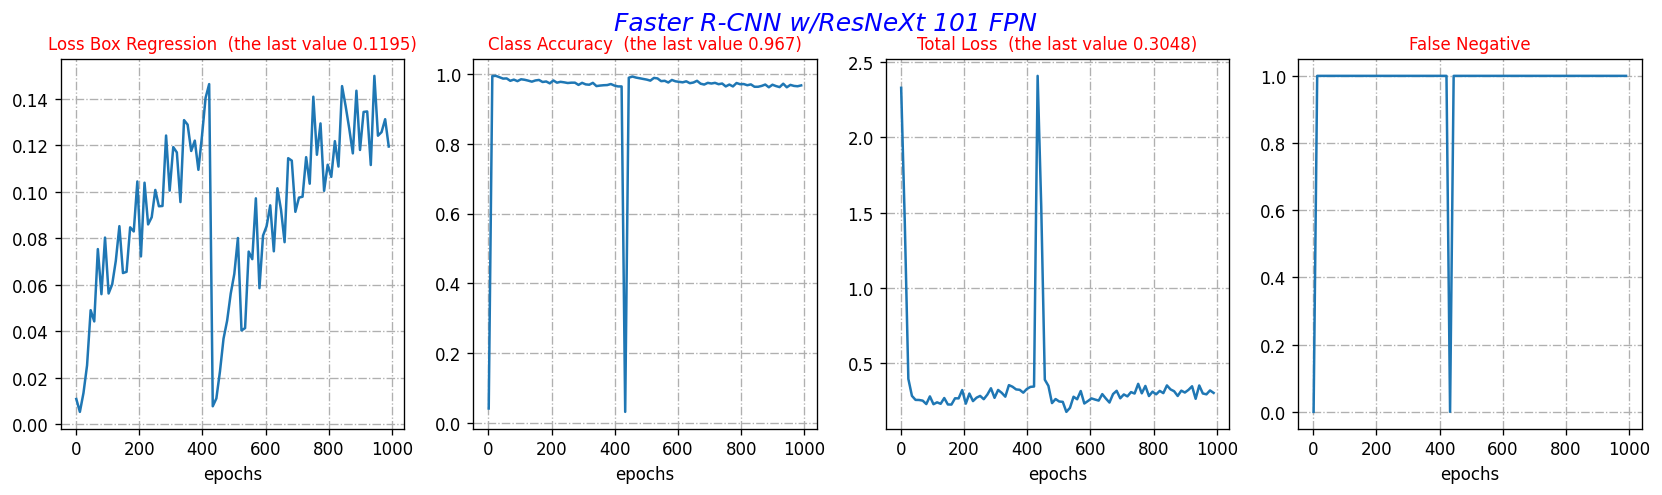

In [ ]:
def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

train_metrics = reading_metrics_from_json('/content/drive/MyDrive/BoneFractureDataset/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [ ]:
with open("/content/drive/MyDrive/BoneFractureDataset/cfg.pkl", "rb") as f:
    cfg = pickle.load(f)

cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.OUTPUT_DIR = '/content/drive/MyDrive/BoneFractureDataset/output/'
predictor = DefaultPredictor(cfg)

[05/27 15:45:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/BoneFractureDataset/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


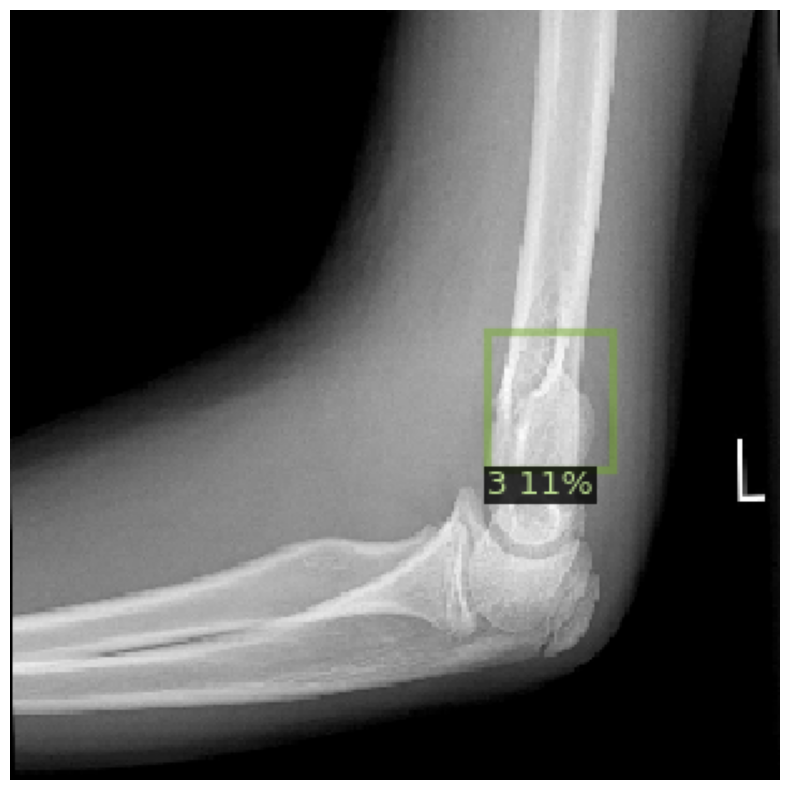


----------------------------------------
Bounding Boxes : [[158.39722 106.50416 199.72261 152.4228 ]]
Type of fracture : humerus fracture
----------------------------------------


In [ ]:
import cv2
from detectron2.utils.visualizer import Visualizer

# Some Random Image from the dataset
img_path = '/content/drive/MyDrive/BoneFractureDataset/train/images/fracture-of-the-humeral-capitellum-milch-type-1-1-1-_jpg.rf.f40a3ca2a57d511a40839bd1ca615d54.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img , (256 , 256))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = predictor(img)

instances = output["instances"]
boxes = instances.pred_boxes if instances.has("pred_boxes") else None
class_id = instances.pred_classes if instances.has("pred_classes") else None

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

v = Visualizer(img, metadata, scale=1.2)
v = v.draw_instance_predictions(instances.to("cpu"))
result_img = v.get_image()

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(result_img)
plt.axis("off")
plt.show()

if boxes is not None:
    boxes = boxes.tensor.cpu().numpy()
if class_id is not None:
    class_names = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive' , 'No Fracture']
    class_id = class_id.cpu().numpy()
    classes = class_names[int(class_id[0])]

print('\n'+ '-' * 40)
print(f"Bounding Boxes : {boxes}")
print(f"Type of fracture : {classes}")
print( '-' * 40)